## Test the Performance of our GPS

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from path_emersion import PathEmersioner
from ridepath_plan import RidePlaner
import pymap3d as pm

%matplotlib inline

Find the Location of Rosbag

In [2]:
os.chdir('/home/yinqiang/baidumap_navigation')
hku_demo_dir = 'hku_bag'
hku_demo_name = 'hku_demo_01.bag'
bag_file = os.path.join(os.getcwd(), hku_demo_dir, hku_demo_name) 
print('Rosbag full path: {}'.format(bag_file))

Rosbag full path: /home/yinqiang/baidumap_navigation/hku_bag/hku_demo_01.bag


Extract the GPS information here. First initialize the method to extract GPS information with Baidu Map

In [3]:
emersioner = PathEmersioner()
center_lng, center_lat, markers_gps = emersioner.obtain_path(bag_file)

gps_marker_list = markers_gps.split(';')
gps_list = list()
for gps_pair in gps_marker_list:
    gps_values = list(float(value) for value in gps_pair.split(','))
    gps_list.append(gps_values)

gps_list = np.array(gps_list)
print('Length of GPS list: {}'.format(gps_list.shape[0]))

Length of GPS list: 89


Draw a small subpath measured by GPS sensors

In [4]:
# previous path visualization
valid_gps_markers = ';'.join(gps_marker_list[:35])
emersioner.save_path(center_lng, center_lat, valid_gps_markers)

In [5]:
# Path replanner by Baidu Map
planner = RidePlaner()
start_gps = ','.join([str(coord) for coord in reversed(gps_list[0, :].tolist())])
end_gps = ','.join([str(coord) for coord in reversed(gps_list[34, :].tolist())])
print('Start point: {}'.format(start_gps))
print('End point: {}'.format(end_gps))
center_lng, center_lat, planned_markers_gps = planner.calculate_path(start_gps, end_gps)
# planner.save_path(center_lng, center_lat, markers_gps)

Start point: 22.2844866,114.1381188
End point: 22.2835301,114.1391492


In [6]:
# GPS value in Baidu coordinate
planned_gps_marker_list = planned_markers_gps.split(';')
planned_gps_list = list()
for gps_pair in planned_gps_marker_list:
    gps_values = list(float(value) for value in gps_pair.split(','))
    planned_gps_list.append(gps_values)
    
planned_gps_list = np.array(planned_gps_list)
# GPS values in WGS84 coordinate
valid_gps_list = gps_list[:35, :]

# output
print('WGS84 start: {}'.format(valid_gps_list[0]))
print('Baidu start: {}'.format(planned_gps_list[0]))

WGS84 start: [ 114.1381188   22.2844866]
Baidu start: [ 114.14961872   22.28791655]


### 1. single reference origin

In [7]:
def single_origin_enu(gps_list, ref_pos):
    enu_list = list()
    lon0, lat0 = ref_pos
    for (lon, lat) in gps_list:
        enu = pm.geodetic2enu(lat, lon, 0.0, lat0, lon0, 0.0)
        enu_list.append(enu[:-1])
    return np.array(enu_list)

In [8]:
def traj_visualization(A_list, B_list):
    plt.figure(figsize=(10,10))
    # measured GPS list
    plt.plot(A_list[:, 0], A_list[:, 1], color='r', linewidth=2, 
            marker='o', markersize=6, markerfacecolor='b', markeredgecolor='b', label='Measured')
    # planned GPS list
    plt.plot(B_list[:, 0], B_list[:, 1], color='orange', linewidth=2, 
            marker='o', markersize=6, markerfacecolor='g', markeredgecolor='g', label='Planned')
    plt.grid()
    plt.xlabel('East-West')
    plt.ylabel('North-South')
    plt.title('Single Reference Origin')
    plt.legend()
    ax = plt.gca()
    ax.set_aspect(1./ax.get_data_ratio())
    plt.tight_layout()

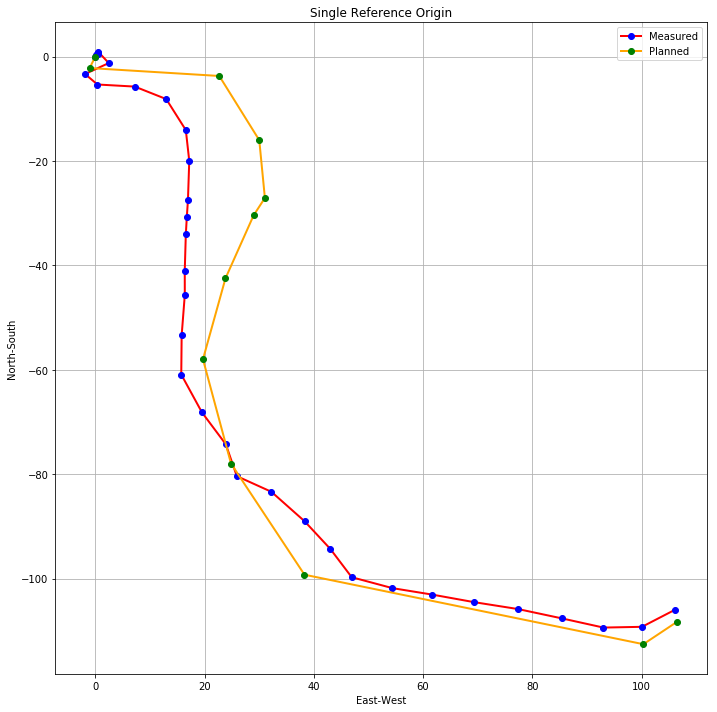

In [13]:
# 1. real data trajectory
measured_enu_list = single_origin_enu(valid_gps_list, valid_gps_list[0])
# 2. planned GPS list
planned_enu_list = single_origin_enu(planned_gps_list, planned_gps_list[0])

traj_visualization(measured_enu_list, planned_enu_list)
# plt.savefig('Compare_figure.jpg', dpi=400)

### 2. local reference origin

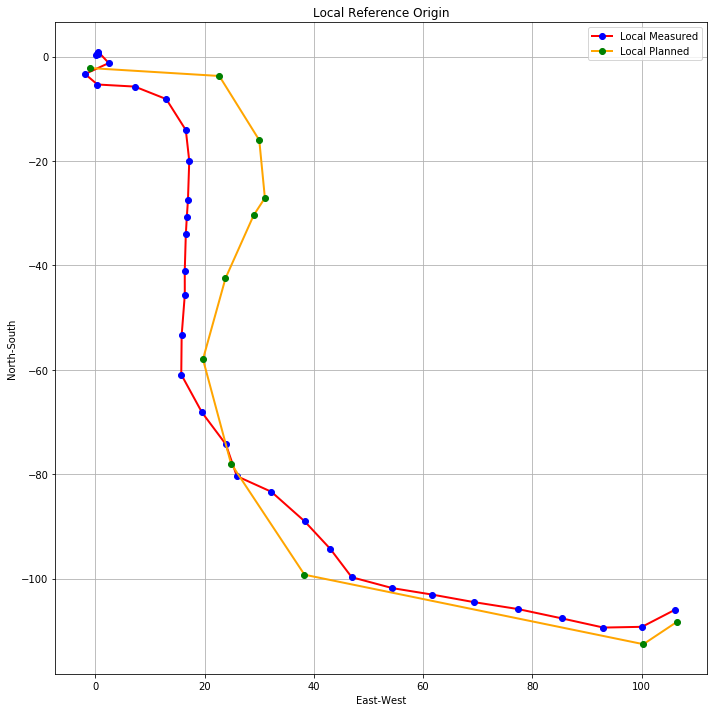

In [10]:
# real data trajectory
rel_measured_enu_list = list()
for idx, (lon, lat) in enumerate(valid_gps_list[1:].tolist()):
    lon0, lat0 = valid_gps_list[idx].tolist()
    enu = pm.geodetic2enu(lat, lon, 0.0, lat0, lon0, 0.0)
    rel_measured_enu_list.append(list(enu[:-1]))
rel_measured_enu_list = np.array(rel_measured_enu_list)
local_measured_enu_list = np.cumsum(rel_measured_enu_list, axis=0)

# planned data trajectory
rel_planned_enu_list = list()
for idx, (lon, lat) in enumerate(planned_gps_list[1:].tolist()):
    lon0, lat0 = planned_gps_list[idx].tolist()
    enu = pm.geodetic2enu(lat, lon, 0.0, lat0, lon0, 0.0)
    rel_planned_enu_list.append(list(enu[:-1]))
rel_planned_enu_list = np.array(rel_planned_enu_list)
local_planned_enu_list = np.cumsum(rel_planned_enu_list, axis=0)


plt.figure(figsize=(10,10))
# local measured GPS list
plt.plot(local_measured_enu_list[:, 0], local_measured_enu_list[:, 1], color='r', linewidth=2, 
         marker='o', markersize=6, markerfacecolor='b', markeredgecolor='b', label='Local Measured')
# measured GPS list
plt.plot(local_planned_enu_list[:, 0], local_planned_enu_list[:, 1], color='orange', linewidth=2, 
         marker='o', markersize=6, markerfacecolor='g', markeredgecolor='g', label='Local Planned')
plt.grid()
plt.xlabel('East-West')
plt.ylabel('North-South')
plt.title('Local Reference Origin')
plt.legend()
ax = plt.gca()
ax.set_aspect(1./ax.get_data_ratio())
plt.tight_layout()

In [11]:
# check planned trajectory with different starts
start_index = 13
start_gps_02 = ','.join([str(coord) for coord in reversed(gps_list[start_index, :].tolist())])
end_gps_02 = ','.join([str(coord) for coord in reversed(gps_list[34, :].tolist())])
print('Start point: {}'.format(start_gps_02))
# print('End point: {}'.format(end_gps))
_, _, planned_markers_gps_02 = planner.calculate_path(start_gps_02, end_gps_02)


# GPS values in Baidu coordinates with different starts
planned_gps_marker_list_02 = planned_markers_gps_02.split(';')
planned_gps_list_02 = list()
for gps_pair in planned_gps_marker_list_02:
    gps_values = list(float(value) for value in gps_pair.split(','))
    planned_gps_list_02.append(gps_values)
    
planned_gps_list_02 = np.array(planned_gps_list_02)

# print('WGS84 start: {}'.format(gps_list[3, :].tolist()))
print('Baidu start: {}'.format(planned_gps_list_02[0]))

Start point: 22.2842386,114.1382834
Baidu start: [ 114.14978939   22.28766371]


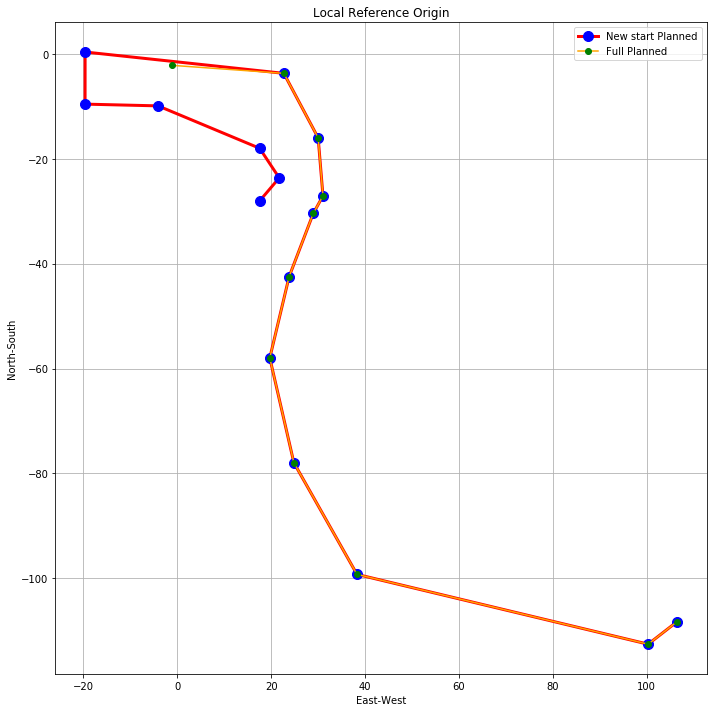

In [12]:
# planned data trajectory
local_planned_enu_list_02 = single_origin_enu(planned_gps_list_02, planned_gps_list[0])

# visualization
plt.figure(figsize=(10,10))
# local measured GPS list
plt.plot(local_planned_enu_list_02[:, 0], local_planned_enu_list_02[:, 1], color='r', linewidth=3, 
         marker='o', markersize=10, markerfacecolor='b', markeredgecolor='b', label='New start Planned')
# measured GPS list
plt.plot(local_planned_enu_list[:, 0], local_planned_enu_list[:, 1], color='orange', linewidth=1.5, 
         marker='o', markersize=6, markerfacecolor='g', markeredgecolor='g', label='Full Planned')
plt.grid()
plt.xlabel('East-West')
plt.ylabel('North-South')
plt.title('Local Reference Origin')
plt.legend()
ax = plt.gca()
ax.set_aspect(1./ax.get_data_ratio())
plt.tight_layout()